In [2]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

def analyze_gamma_power_over_time(epochs_emotion1, epochs_emotion2, sfreq=250, window_size=1.0, overlap=0.5):
    """
    Analyze gamma power changes over time for joy and anger conditions.
    
    Parameters:
    -----------
    epochs_emotion1 : mne.Epochs
        Epochs for emotion 1
    epochs_emotion2 : mne.Epochs
        Epochs for emotion 2
    sfreq : float
        Sampling frequency in Hz
    window_size : float
        Size of sliding window in seconds
    overlap : float
        Overlap between windows in seconds
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing gamma power values over time for both conditions
    """
    def calculate_gamma_power(data, sfreq):
        # Calculate power in gamma band (30-100 Hz)
        freqs, psd = signal.welch(data, fs=sfreq, nperseg=min(256, len(data)))
        gamma_mask = (freqs >= 30) & (freqs <= 100)
        return np.mean(psd[gamma_mask])
    
    # Calculate window parameters
    window_samples = int(window_size * sfreq)
    overlap_samples = int(overlap * sfreq)
    step_samples = window_samples - overlap_samples
    
    results = []
    
    # Process both emotions
    for emotion, epochs in [('emotion1', epochs_emotion1), ('emotion2', epochs_emotion2)]:
        data = epochs.get_data()
        
        # Process each epoch
        for epoch_idx in range(len(epochs)):
            # Get epoch data
            epoch_data = data[epoch_idx]
            
            # Calculate time points for windows
            n_windows = int((epoch_data.shape[1] - overlap_samples) / step_samples)
            
            # Process each window
            for win_idx in range(n_windows):
                start_idx = win_idx * step_samples
                end_idx = start_idx + window_samples
                
                if end_idx > epoch_data.shape[1]:
                    break
                
                # Calculate time in seconds from epoch start
                time = (start_idx + window_samples/2) / sfreq
                
                # Determine condition (1: neutral, 2: emotional)
                condition = 2 if time > 20 else 1
                
                # Calculate gamma power for each channel
                for ch_idx, ch_name in enumerate(epochs.ch_names):
                    window_data = epoch_data[ch_idx, start_idx:end_idx]
                    gamma_power = calculate_gamma_power(window_data, sfreq)
                    
                    results.append({
                        'emotion': emotion,
                        'epoch': epoch_idx,
                        'time': time,
                        'condition': condition,
                        'channel': ch_name,
                        'gamma_power': gamma_power
                    })
    
    return pd.DataFrame(results)

def plot_gamma_power_results(df):
    """
    Create visualizations of gamma power analysis results.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing gamma power analysis results
    """
    # Calculate mean gamma power across channels and epochs
    summary_df = df.groupby(['emotion', 'time']).agg({
        'gamma_power': ['mean', 'sem']
    }).reset_index()
    summary_df.columns = ['emotion', 'time', 'mean_power', 'sem']
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    for emotion in ['emotion1','emotion2']:
        data = summary_df[summary_df['emotion'] == emotion]
        plt.plot(data['time'], data['mean_power'], label=emotion)
        plt.fill_between(data['time'],
                        data['mean_power'] - data['sem'],
                        data['mean_power'] + data['sem'],
                        alpha=0.3)
    
    plt.axvline(x=20, color='r', linestyle='--', label='Condition Change')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gamma Power')
    plt.title('Temporal Evolution of Gamma Power')
    plt.ylim((0.05,0.12))
    plt.legend()
    plt.grid(True)
    
    # Add annotations
    plt.text(10, plt.ylim()[1], '(Neutral stimulus)', 
             horizontalalignment='center', verticalalignment='top')
    plt.text(25, plt.ylim()[1], '(Emotional stimulus)', 
             horizontalalignment='center', verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# Example usage:
def example_usage(epochs_emotion1, epochs_emotion2):
    # Analyze gamma power
    results_df = analyze_gamma_power_over_time(epochs_emotion1, epochs_emotion2)
    
    # Create visualizations
    plot_gamma_power_results(results_df)
    
    return results_df

In [11]:
emotion2_preprocessed = mne.io.read_raw_fif("..\\..\\data\\preprocessed\\eeg_1738123456789_emotion2_preprocessed.fif", preload=True)
emotion2_epochs = mne.make_fixed_length_epochs(emotion2_preprocessed, duration=30, preload=False, reject_by_annotation=False).drop_bad(reject={"eeg": 150})
emotion1_preprocessed = mne.io.read_raw_fif("..\..\data\preprocessed\eeg_1738987654321_emotion1_preprocessed.fif", preload=True)
emotion1_epochs = mne.make_fixed_length_epochs(emotion1_preprocessed, duration=30, preload=False, reject_by_annotation=False).drop_bad(reject={"eeg": 150})

Opening raw data file ..\..\data\preprocessed\eeg_1738123456789_emotion2_preprocessed.fif...
Isotrak not found
    Range : 1250 ... 181669 =      5.000 ...   726.676 secs
Ready.
Reading 0 ... 180419  =      0.000 ...   721.676 secs...
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 7500 original time points ...
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
3 bad epochs dropped
Opening raw data file ..\..\data\preprocessed\eeg_1738987654321_emotion1_preprocessed.fif...


<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
C:\Users\pegger\AppData\Local\Temp\ipykernel_14880\4259422069.py:3: SyntaxWarning: invalid escape sequence '\.'
  emotion1_preprocessed = mne.io.read_raw_fif("..\..\data\preprocessed\eeg_1738987654321_emotion1_preprocessed.fif", preload=True)
C:\Users\pegger\AppData\Local\Temp\ipykernel_14880\4259422069.py:1: RuntimeWarning: This filename (..\..\data\preprocessed\eeg_1738123456789_emotion2_preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  emotion2_preprocessed = mne.io.read_raw_fif("..\\..\\data\\preprocessed\\eeg_1738123456789_emotion2_preprocessed.fif", preload=True)
C:\Users\pegger\AppData\Local\Temp\ipykernel_14880\4259422069.py:3: RuntimeWarning: This filename (..\..\data\preprocessed\eeg_

Isotrak not found
    Range : 1250 ... 181849 =      5.000 ...   727.396 secs
Ready.
Reading 0 ... 180599  =      0.000 ...   722.396 secs...
Not setting metadata
24 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 24 events and 7500 original time points ...
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
    Rejecting  epoch based on EEG : ['ch1']
6 bad epochs dropped


Using data from preloaded Raw for 18 events and 7500 original time points ...
Using data from preloaded Raw for 21 events and 7500 original time points ...


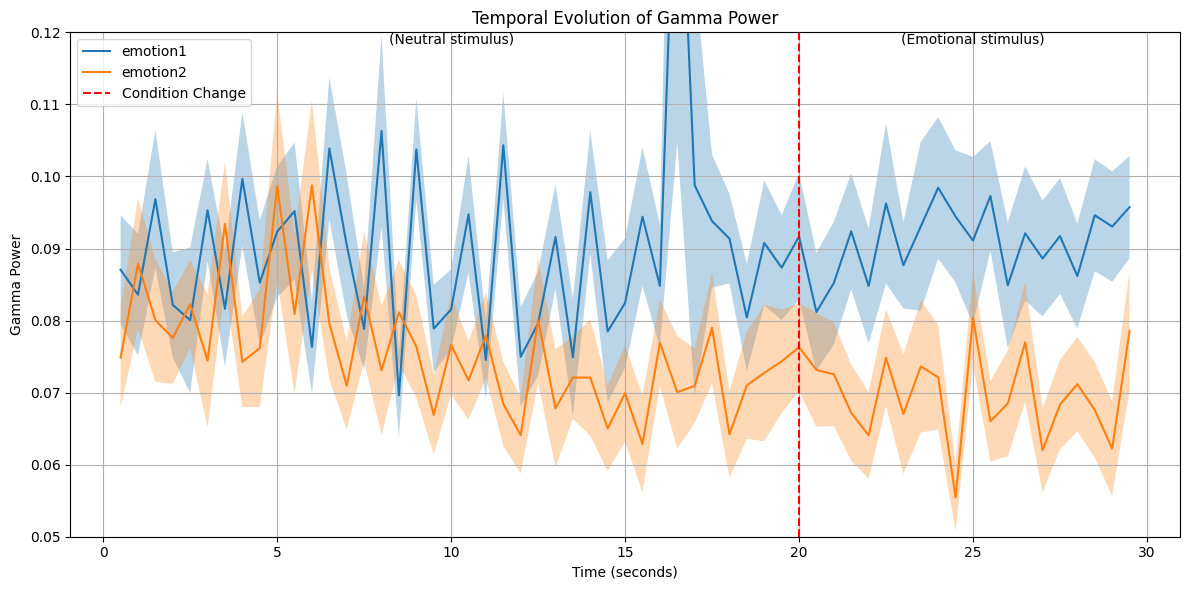

,emotion,epoch,time,condition,channel,gamma_power
0,emotion1,0,0.5,1,ch1,0.055079
1,emotion1,0,1.0,1,ch1,0.197080
2,emotion1,0,1.5,1,ch1,0.104062
3,emotion1,0,2.0,1,ch1,0.076036
4,emotion1,0,2.5,1,ch1,0.118479
...,...,...,...,...,...,...
2296,emotion2,20,27.5,2,ch1,0.046825
2297,emotion2,20,28.0,2,ch1,0.135231
2298,emotion2,20,28.5,2,ch1,0.031603
2299,emotion2,20,29.0,2,ch1,0.101436


In [13]:
example_usage(emotion1_epochs, emotion2_epochs)